# Lab 11: _Super-resolved spatial transcriptomics_

Spatial Omics Data Analysis 2022

2022-09-02


## Background

Capture-based spatial transcriptomics technologies, such as Visium, can quantify the abundance of all polyadenylated transcripts in a single experiment.
In contrast, imaging-based methods, for example fluorescent in-situ hybridization (FISH) or in-situ sequencing (ISS), target only a limited set of transcripts.
While the capture-based methods thus are good at comprehensively characterizing the transcriptome, they suffer from relatively low sensitivity and resolution.

In this lab, we will implement a simplified version of the model presented in [1] to improve the resolution of a capture-based spatial transcriptomics dataset.

## Preface

This lab makes extensive use of the deep learning library [PyTorch](https://pytorch.org/).
If you are new to machine learning, don't worry!
We will explain the most important parts of the model and link to optional external resources if you want to go deeper.
The goal of the lab is to give you a better understanding of how the method presented in [1] works.

It is recommended that you use a GPU-enabled version of PyTorch.
If your computer does not have a GPU, you can run the notebook on [Google Colab](https://colab.research.google.com/): Open the notebook by clicking the Upload tab and selecting it from your computer.

## Installing dependencies

Let's first install the Python dependencies needed for this lab:

In [1]:
!pip install -q gdown matplotlib numpy imageio pandas scikit-image scipy torch torchvision

## Dataset

We will use a dataset from [2] consisting of 12 section from the mouse olfactory bulb.
Let's begin by downloading the data files:

In [2]:
!if [ ! -f lab11_files.tar.gz ]; then gdown 1eZWd-MjOXE7iO33rkEOr49pynP-Iyv4Y; fi
!tar xf lab11_files.tar.gz

Downloading...
From: https://drive.google.com/uc?id=1eZWd-MjOXE7iO33rkEOr49pynP-Iyv4Y
To: /content/lab11_files.tar.gz
100% 77.0M/77.0M [00:02<00:00, 30.0MB/s]


### Preprocessing
<a name="preprocessing"></a>

We will next introduce functions to preprocess the downloaded data files.
While the ''spots'' (capture locations) on the ST array are circular, we will make the simplifying assumption that they form a pixel grid without any spacing.
Additionally, we will downsample the histology images to a size that is a fixed multiple of the count data.

In [3]:
import numpy as np
import pandas as pd
from imageio import imread
from scipy.ndimage import map_coordinates


def transform_coordinates(transformation_matrix, coordinates):
    """Transforms coordinate array with given transformation matrix.

    Args:
        transformation_matrix: A 3x3 transformation matrix.
        coordinates: A Nx2 array of coordinates.
    Returns:
        A Nx2 array of transformed coordinates.
    """
    # Convert to homogeneous coordinates
    coordinates_h = np.append(coordinates, np.ones((1, *coordinates.shape[1:])), 0)
    # Apply transformation
    transformed_coordinates_h = transformation_matrix @ coordinates_h.reshape(3, -1)
    # Convert back to cartesian coordinates
    transformed_coordinates = transformed_coordinates_h[:2].reshape(coordinates.shape)
    return transformed_coordinates


def normalize(x):
    """Normalize image to [0, 1].

    Args:
        x: A HxWxC image.
    Returns:
        Channel-wise normalized image.
    """
    x = x - x.min((0, 1))
    x = x / x.max((0, 1))
    return x


def load_data(
    he_image_path,
    count_matrix_path,
    transformation_matrix_path,
    scale_factor=16,
    genes=None,
):
    """Load data from ST1k experiment.

    Args:
        he_image_path: Path to HE image.
        count_matrix_path: Path to count matrix.
        transformation_matrix_path: Path to transformation matrix.
        scale_factor: Scale factor for HE image relative to count data.
        genes: List of genes to load. If None, load all genes.
    Returns:
        A tuple of (HE image, count data image).
    """
    ## 1. Load count data
    counts_df = pd.read_csv(count_matrix_path, sep="\t", index_col=0)

    # Subset genes
    if genes is not None:
        counts_df = counts_df[genes]
    else:
        genes = counts_df.columns.values.astype(str)

    counts = np.array(counts_df.values)
    spot_coordinates = np.array(
        [tuple(map(float, x.split("x"))) for x in counts_df.index]
    )

    ## 2. Load transformation matrix
    transformation_matrix = np.loadtxt(transformation_matrix_path)
    transformation_matrix = transformation_matrix.reshape(3, 3)

    # Transformation matrix and spot coordinates use (x, y) convention.
    # We switch here to (y, x), which is consistent with numpy array order.
    transformation_matrix[:, :2] = transformation_matrix[:, :2][:, ::-1]
    transformation_matrix[:2, :] = transformation_matrix[:2, :][::-1, :]
    spot_coordinates = spot_coordinates.round().astype(int)[:, ::-1]

    ## 3. Construct "gene image" (HxWxG tensor of gene counts)
    H_array_min, W_array_min = spot_coordinates.min(axis=0)
    H_array_max, W_array_max = spot_coordinates.max(axis=0) + 1
    H_array, W_array = H_array_max - H_array_min, W_array_max - W_array_min
    gene_image = np.zeros((H_array, W_array, len(genes)))
    gene_image[
        tuple((spot_coordinates - np.array([H_array_min, W_array_min])).T)
    ] = counts
    gene_image = normalize(gene_image)

    ## 4. Construct histology image
    # Compute pixel coordinates to sample the histology image from
    H_min, W_min = (scale_factor * x for x in (H_array_min, W_array_min))
    H_max, W_max = (scale_factor * x for x in (H_array_max, W_array_max))
    H, W = H_max - H_min, W_max - W_min
    pixel_coordinates = transform_coordinates(
        (np.diag([1 / scale_factor, 1 / scale_factor, 1]) @ transformation_matrix).T,
        np.indices([H_max, W_max])[:, H_min:, W_min:] - (scale_factor - 1) / 2 + 1,
    )
    pixel_coordinates = np.append(
        np.repeat(pixel_coordinates[None], 3, 0),
        np.broadcast_to(np.arange(3)[:, None, None, None], (3, 1, H, W)),
        axis=1,
    )
    pixel_coordinates = pixel_coordinates.transpose(1, 2, 3, 0)

    # Load and sample histology image
    he_image_orig = imread(he_image_path)
    he_image = map_coordinates(he_image_orig, pixel_coordinates, order=1)
    he_image = normalize(he_image)

    return he_image, gene_image

We are now ready to preprocess the downloaded data files.
We will set the size of the histology image to 8 times the resolution of the gene expression data and limit the analysis to the 100 highest-expressed genes in the dataset.

In [4]:
genes = np.array(["Ckb", "Cst3", "Apoe", "Eef1a1", "Cpe", "Sparcl1", "Ndrg4", "Glul", "Tuba1a", "Itm2b", "Atp5b", "Actb", "Calm2", "Pcp4", "Vamp2", "Scd2", "Calm1", "Fth1", "Snap25", "Aldoa", "Ddx5", "Rplp1", "Ubb", "Ppia", "Atp5a1", "Hsp90aa1", "Atp1b1", "Hspa8", "Tspan7", "Rtn3", "Mbp", "Actg1", "Tmsb4x", "2900097C17Rik", "Gm1821", "Mdh1", "Ldhb", "Gpm6a", "Tubb2a", "Cfl1", "Pcp4l1", "Slc1a2", "Rtn4", "Apod", "Atp5g3", "Cox4i1", "Psap", "Slc25a3", "Itm2c", "Cdr1", "Rpl13", "Ttc3", "Eef2", "Cox6a1", "Rpl41", "Map1b", "Sepp1", "Tpt1", "Cdhr1", "Ptgds", "Hsp90ab1", "Rab3a", "Meg3", "Gpm6b", "Morf4l1", "Syt11", "H3f3b", "Synpr", "Rtn1", "Serinc1", "6330403K07Rik", "Nsg2", "Calm3", "Gapdh", "Celf2", "Gad1", "Uba52", "Camk2n1", "Olfm1", "Slc1a3", "Slc6a1", "Purb", "Syt1", "Mapk1", "Marcks", "Map2", "Dnm1", "Meis2", "Stxbp1", "Stmn3", "Cplx1", "Dlgap1", "Pkm", "Qk", "Eif1", "Ywhae", "Aldoc", "Tuba1b", "Mir703", "Snap91"])
scale_factor = 8

gene2idx = {g: i for i, g in enumerate(genes)}

import os
from glob import glob

he_images, gene_images = [], []
for data_path in glob("data/*"):
    he_image, gene_image = load_data(
        os.path.join(data_path, "image.jpg"),
        os.path.join(data_path, "counts.tsv"),
        os.path.join(data_path, "tmat.txt"),
        scale_factor=scale_factor,
        genes=genes,
    )
    he_images.append(he_image)
    gene_images.append(gene_image)

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (91981508 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (92113450 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (91933800 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (92215695 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:2800: DecompressionBombWarning: Image size (92278212 pixels) exceeds limit of 89478485 p

### What does the preprocessed data look like?

To get a sense of what the data looks like, let's plot the expression of _Pcp4_ ontop of the histology images:

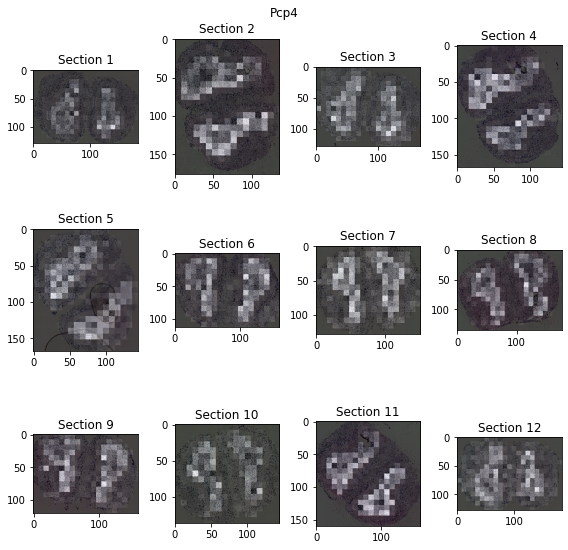

In [5]:
import matplotlib.pyplot as plt
from skimage.transform import resize


plt.rcParams['figure.figsize'] = (8, 8)

ncols = int(np.ceil(np.sqrt(len(gene_images))))
nrows = int(np.ceil(len(gene_images) / ncols))
f, axs = plt.subplots(nrows, ncols)
for i, (ax, hi, gi) in enumerate(zip(axs.ravel(), he_images, gene_images), 1):
  gi = resize(gi[..., gene2idx["Pcp4"]], hi.shape[:2], order=0)
  ax.imshow(0.3 * hi + 0.7 * gi[..., None])
  ax.set_title(f"Section {i}")

plt.tight_layout()
plt.suptitle("Pcp4")
plt.show()

We can see that _Pcp4_ appears to be overexpressed in the Granule cell layer of the olfactory bulb.

## Defining the super-resolution model

It is now time to define our super-resolution model!
The model that we will use is a simplified version of the one described in [1].

Instead of factorizing the gene expression over _metagenes_ (collections of genes with similar expression patterns) as in [1], will we make use of a unique _feature embedding_ for each gene.
The feature embedding can be seen as a signature for the gene, telling us how it is associated to the histology data.

Similar to [1], we will use a U-Net-like architecture that captures the latent state of the tissue over multiple resolutions:

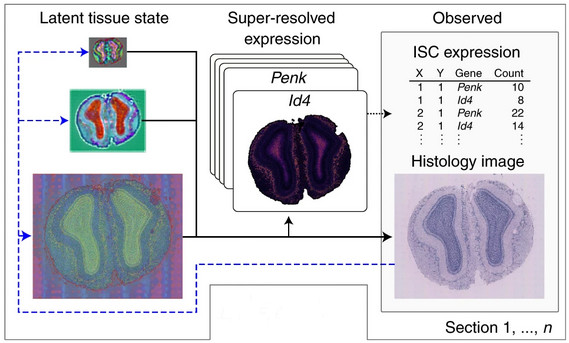

If you haven't used PyTorch before, the code below may look unfamiliar.
Following PyTorch conventions, we define the model as an `nn.Module` subclass.
An `nn.Module` comprises the parameters of the model (initialized in the `__init__` method) and a `forward` method for running the model.
In our case, the `forward` method takes as input a histology image and a gene index (an integer in $\{1\ldots G\}$, where $G$ is the number of genes in the dataset).
It first runs an _inference network_ (blue dashed arrows in the figure above) that computes the associated latent state from the histology image.
Then, it passes the latent state and gene index to a _generator network_ (black arrows) that tries to reconstruct the histology image and additionally outputs a super-resolved expression map of the same resolution as the histology image for the gene associated with the gene index.

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Model(nn.Module):
    def __init__(self, num_genes, latent_dim=32, num_resolutions=3):
        super().__init__()

        # Compute latent state size for each resolution
        dims = [2**i * latent_dim for i in range(num_resolutions)]

        # Initialize pre-encoder that embeds the histology image in higher-dimensional space
        self.enc1 = nn.Conv2d(3, latent_dim, kernel_size=3, padding=1)

        # Initialize inference network submodules
        self.downsamplers, self.downblocks = nn.ModuleList(), nn.ModuleList()
        for dim1, dim2 in zip(dims[:-1], dims[1:]):
            self.downsamplers.append(nn.Sequential(nn.ReLU(), nn.Conv2d(dim1, dim2, kernel_size=3, stride=2, padding=1)))
            self.downblocks.append(nn.Sequential(nn.ReLU(), nn.Conv2d(dim2, dim2, kernel_size=3, padding=1)))

        # Initialize encoders for the variational distribution
        self.q_encoders = nn.ModuleList()
        for dim in dims:
            self.q_encoders.append(nn.Sequential(nn.ReLU(), nn.Conv2d(dim, 2 * dim, kernel_size=3, padding=1)))

        # Initialize generator network submodules
        self.upsamplers, self.upblocks = nn.ModuleList(), nn.ModuleList()
        for dim1, dim2 in zip(dims[1:], dims[:-1]):
            self.upsamplers.append(nn.Sequential(nn.ReLU(), nn.UpsamplingNearest2d(scale_factor=2), nn.Conv2d(dim1, dim2, kernel_size=3, padding=1)))
            self.upblocks.append(nn.Sequential(nn.ReLU(), nn.Conv2d(2 * dim2, dim2, kernel_size=3, padding=1)))

        # Initialize histology image decoder
        self.hi_decoder = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(latent_dim, latent_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(latent_dim, 2 * 3, kernel_size=1),
        )

        # Initialize gene embedding and gene image decoder
        self.gidx_embedding = nn.Embedding(num_genes, latent_dim)
        self.gi_decoder = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(latent_dim, latent_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(latent_dim, 2 * 1, kernel_size=1),
        )

    def forward(self, x, gidx):
        x = self.enc1(x)

        # Run inference network
        hs = [x]
        for ds, db in zip(self.downsamplers, self.downblocks):
            x = ds(x)
            x = db(x)
            hs.append(x)

        # Compute variational distributions and sample latent state `z`
        q_mus, q_sds, p_mus, p_sds,  zs = [], [], [], [], []
        for q_encoder, h in zip(self.q_encoders, hs):
            q_mu, q_sd = q_encoder(h).chunk(2, dim=1)
            q_sd = F.softplus(q_sd) + 1e-3
            q_mus.append(q_mu);
            q_sds.append(q_sd)
            p_mus.append(torch.zeros_like(q_mu))
            p_sds.append(torch.ones_like(q_sd))

            z = q_mu + q_sd * torch.randn_like(q_mu)
            zs.append(z)

        # Run generator network
        *zs, x = zs
        for us, ub, z in reversed(list(zip(self.upsamplers, self.upblocks, zs))):
            x = us(x)
            x = torch.cat([x, z], dim=1)
            x = ub(x)

        # Compute histology image likelihood
        hi_mu, hi_sd = self.hi_decoder(x).chunk(2, dim=1)
        hi_mu = torch.sigmoid(hi_mu)
        hi_sd = F.softplus(hi_sd) + 1e-3

        # Embed gene index and compute super-resolved gene expression likelihood
        gidx_emb = self.gidx_embedding(gidx)[:, :, None, None]
        gi_mu, gi_sd = self.gi_decoder(x + gidx_emb).chunk(2, dim=1)
        gi_mu = torch.sigmoid(gi_mu.squeeze(1))
        gi_sd = F.softplus(gi_sd).squeeze(1) + 1e-3

        return zs, (q_mus, q_sds), (p_mus, p_sds), (hi_mu, hi_sd), (gi_mu, gi_sd)

## Training

### Dataloader
<a name="the-dataloader"></a>

In order to train the model, we first need to define a dataloader.
The dataloader will feed the model with new training examples from the dataset to learn from.
We follow the patch-based training strategy used in [1], whereby small patches of the spatial expression data along with the associated regions of the histology images are extracted.

In [7]:
import torch.utils.data as data


def training_examples_from(he_image, gene_image, patch_size=8):
    """Creates a generator of training patches from a given ST experiment.

    Args:
        he_image: HE image from the experiment.
        gene_image: Gene image.
        patch_size: Size of patches in number of gene_image pixels (i.e., ST
          "spots")
    Returns:
        Generator of training examples. Each example is a tuple of (HE image,
        gene image, gene index).
    """
    assert he_image.shape[0] % gene_image.shape[0] == 0
    scale_factor = he_image.shape[0] // gene_image.shape[0]
    assert scale_factor * gene_image.shape[1] == he_image.shape[1]

    for h in range(gene_image.shape[0] - patch_size):
        for w in range(gene_image.shape[1] - patch_size):
            for gidx in range(gene_image.shape[-1]):
                hi = he_image[
                    scale_factor * h : scale_factor * (h + patch_size),
                    scale_factor * w : scale_factor * (w + patch_size),
                ]
                gi = gene_image[h : h + patch_size, w : w + patch_size, gidx]
                yield hi, gi, gidx


# The `torch.utils.data.Dataset` class wraps a dataset and provides a unified
# interface that can be used with, for example, `torch.utils.data.DataLoader`
# (see below).
class Dataset(data.Dataset):
    def __init__(self, exampels):
        self.examples = exampels

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, idx):
        hi, gi, gidx = self.examples[idx]
        hi = torch.tensor(hi).permute(2, 0, 1).float()
        gi = torch.tensor(gi).float()
        gidx = torch.tensor(gidx).long()
        return hi, gi, gidx


# Create dataset and dataloader from the preprocessed ST experiments
*he_images_training, he_image_test = he_images
*gene_images_training, gene_image_test = gene_images
training_dataset = data.ConcatDataset([
    Dataset([*training_examples_from(hi, gi)])
    for hi, gi in zip(he_images_training, gene_images_training)
])
dataloader = data.DataLoader(
    training_dataset,
    batch_size=32,
    shuffle=True,
    persistent_workers=True,
    num_workers=1,
    drop_last=True,
)

### Loss function
<a name="loss-function"></a>

The _loss_ is the objective function that is minimized during training.
It will thus directly influence what the model learns.
Since we want the latent state to reflect both the image and spatial expression data, we need one loss term for each modality.

For the image data, we will use the negative log-likelihood computed by the model.
For the spatial expression data, we cannot use the predicted distribution directly, since observations are of lower resolution.
Thus, we first need to sum the pixel-wise expression values in each spot.
Since the expression values in our model are independent (holding the latent state fixed) and normally distributed, their sum will also be normally distributed.

Similar to [1], we learn the posterior of the latent state [variationally](https://en.wikipedia.org/wiki/Variational_Bayesian_methods).
Practically, this means that we maximize the _expected_ log-likelihood of the observations over a learned variational posterior and add a third term to the loss, the Kullback-Leibler divergence between the variational posterior and the prior.
It can be shown that this loss function upper bounds the negative marginal likelihood of the model (for more details see [1]).

In [8]:
def compute_loss(q_mus, q_sds, p_mus, p_sds, hi_mu, hi_sd, gi_mu, gi_sd, hi, gi):
    """Computes the loss for a batch of training examples.

    Args:
        q_mus: Mean of variational posterior
        q_sds: Standard deviation of variational posterior
        p_mus: Mean of prior
        p_sds: Standard deviation of prior
        hi_mu: Mean of histology image
        hi_sd: Standard deviation of histology image
        gi_mu: Mean of gene image
        gi_sd: Standard deviation of gene image
        hi: Histology image
        gi: Gene image
    Returns:
        The loss
    """
    # Histology image likelihood
    hi_likelihood = torch.distributions.Normal(hi_mu, hi_sd).log_prob(hi).sum((1, 2, 3)).mean()

    # Gene image likelihood
    gi_lores_mu = gi_mu.reshape(gi_mu.shape[0], 8, scale_factor, 8, scale_factor).mean((2, 4))
    gi_var = gi_sd.square()
    gi_lores_var = gi_var.reshape(gi_sd.shape[0], 8, scale_factor, 8, scale_factor).sum((2, 4))
    gi_lores_var = gi_lores_var / (scale_factor**2)
    gi_lores_sd = gi_lores_var.sqrt()
    gi_likelihood = torch.distributions.Normal(gi_lores_mu, gi_lores_sd).log_prob(gi).sum((1, 2)).mean()

    # Kullback-Leibler divergence between variational posterior and prior
    q_mu = torch.cat([q_mu.flatten(1) for q_mu in q_mus], dim=1)
    q_sd = torch.cat([q_sd.flatten(1) for q_sd in q_sds], dim=1)
    p_mu = torch.cat([p_mu.flatten(1) for p_mu in p_mus], dim=1)
    p_sd = torch.cat([p_sd.flatten(1) for p_sd in p_sds], dim=1)
    kl_loss = torch.distributions.kl_divergence(
        torch.distributions.Normal(q_mu, q_sd),
        torch.distributions.Normal(p_mu, p_sd),
    )
    kl_loss = kl_loss.sum(1).mean()

    # Sum all loss terms
    # Note: We're computing the gene image likelihood only for a single gene. In
    #       expectation, the gene image loss will be `len(genes)` the size. We
    #       adjust for this here by dividing the two other terms by `len(genes)`.
    loss = -gi_likelihood - hi_likelihood / len(genes) + kl_loss / len(genes)

    return loss

### Training loop

We are now ready to start the training!
To try it out, we will run the training loop for one epoch, which means the model will see each image patch and gene pair once.
In each iteration, model parameters will be updated by gradient descent of the objective function using the [Adam optimizer](https://arxiv.org/abs/1412.6980).

In [9]:
from tqdm import tqdm


num_epochs = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Model(num_genes=len(genes))
model = model.to(device)
optim = torch.optim.Adam(model.parameters(), lr=3e-5)

losses = []
loss_ma = 0.0
for epoch in range(1, num_epochs + 1):
    progress = tqdm(dataloader)
    for hi, gi, gidx in progress:
        hi, gi, gidx = hi.to(device), gi.to(device), gidx.to(device)

        # Compute loss
        _, (q_mus, q_sds), (p_mus, p_sds), (hi_mu, hi_sd), (gi_mu, gi_sd) = model(hi, gidx)
        loss = compute_loss(q_mus, q_sds, p_mus, p_sds, hi_mu, hi_sd, gi_mu, gi_sd, hi, gi)

        # Compute gradient
        optim.zero_grad()
        loss.backward()

        # Update parameters
        optim.step()

        losses.append(loss.item())
        loss_ma = 0.999 * loss_ma + 0.001 * loss.item()
        progress.set_description(f"Epoch {epoch}  Loss {loss_ma:.3e}")

Epoch 1  Loss -7.633e+01: 100%|██████████| 3793/3793 [03:59<00:00, 15.81it/s]


Plotting the loss, we can see that it dropped quickly the first few hundred iterations and then entered into a regime of slower but steady decline:

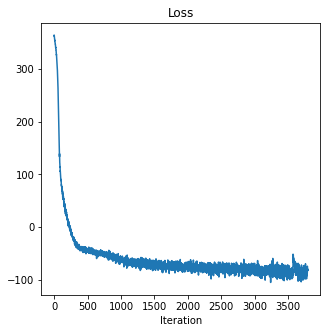

In [10]:
plt.rcParams['figure.figsize'] = (5, 5)
plt.plot(np.arange(len(losses)), losses)
plt.title("Loss")
plt.xlabel("Iteration")
plt.show()

Since the loss is still declining, the model can be improved by training for longer.
However, training the model until convergence is time-consuming and requires at least a few hundred epochs.
To save time, we will therefore use pre-trained weights for the remainder of this lab:

In [11]:
!gdown 1d1MzCL4n0V3eH3VnuFLBabeCGh7tQa0k
model_state = torch.load("model.pt", map_location=device)
model.load_state_dict(model_state, strict=False)

Downloading...
From: https://drive.google.com/uc?id=1d1MzCL4n0V3eH3VnuFLBabeCGh7tQa0k
To: /content/model.pt
100% 3.43M/3.43M [00:00<00:00, 192MB/s]


<All keys matched successfully>

## Inference
<a name="inference"></a>

### Super-resolved expression maps

We can now apply the model to predict super-resolved expression maps.
Let's illustrate with _Pcp4_, which we looked at earlier in the raw expression data, and _Apod_, a gene that is highly expressed in the olfactory nerve layer.

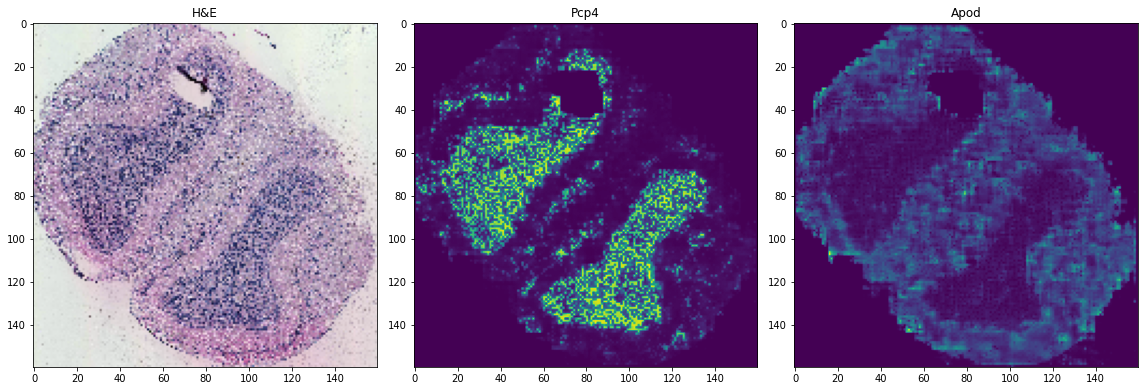

In [12]:
from torchvision.utils import make_grid


def plot(he_image, genes):
  gidx = torch.tensor([gene2idx[g] for g in genes]).long().to(device)
  hi = torch.tensor(he_image).permute(2,0,1).float().to(device)
  hi = hi.unsqueeze(0).broadcast_to((gidx.shape[0], *hi.shape))
  
  with torch.no_grad():
    *_, (pred, _) = model(hi, gidx)
  
  plt.rcParams['figure.figsize'] = (8 * len(genes), 8)
  
  f, axs = plt.subplots(1, 1 + len(genes))
  ax1, *axs = axs.ravel()
  ax1.imshow(he_image)
  ax1.set_title("H&E")
  for ax, gi, g in zip(axs, pred, genes):
    ax.imshow(gi.cpu().numpy())
    ax.set_title(g)
  
  plt.tight_layout()
  plt.show()


plot(he_images_training[-1], ["Pcp4", "Apod"])

We can see that the model predicts higher expression of _Pcp4_ coinciding with cell nuclei in the Granule, Inner Plexiform, and Mitral cell layers and, to some degree, also in the Glomerular layer.
The expression of _Apod_ is more diffuse but concentrated to the Olfactory nerve and External Plexiform layers.

### Gene co-expression patterns
<a name="gene-embed"></a>

The gene embedding is an abstract concept space that describes how genes are associated to histology via the latent tissue state.
It can be used to explore relationships between genes and describe gene co-expression patterns.
To get a sense of what this space looks like, we can project it down to two dimensions using PCA:

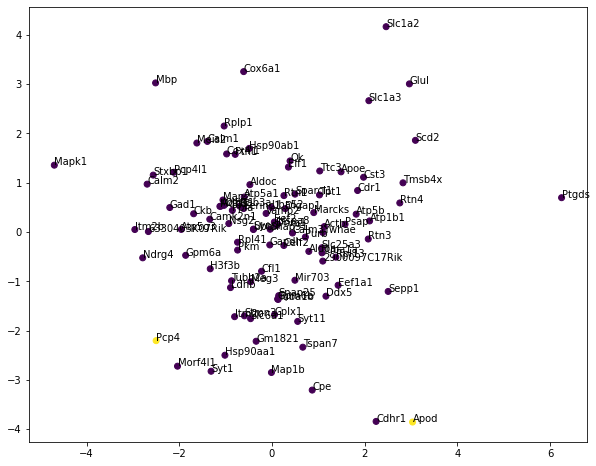

In [13]:
from sklearn.decomposition import PCA

emb = model.gidx_embedding.weight.detach().cpu().numpy()
emb_pca = PCA(n_components=2).fit_transform(emb)

plt.rcParams['figure.figsize'] = (10, 8)
plt.scatter(emb_pca[:, 0], emb_pca[:, 1], c=np.isin(genes, ["Pcp4", "Apod"]))
for g, x, y in zip(genes, emb_pca[:, 0], emb_pca[:, 1]):
    plt.annotate(g, (x, y))
plt.show()

Distances in the embedding space correspond to expression similarity.
Thus, it can be used to identify groups of genes with similar expression patterns.
To demonstrate, let's look at the most immediate neighbors of _Pcp4_ and _Apod_, _Morf4l1_ and _Cdhr1_.
As we can see, their expression patterns largely resemble those of _Pcp4_ and _Apod_, respectively.

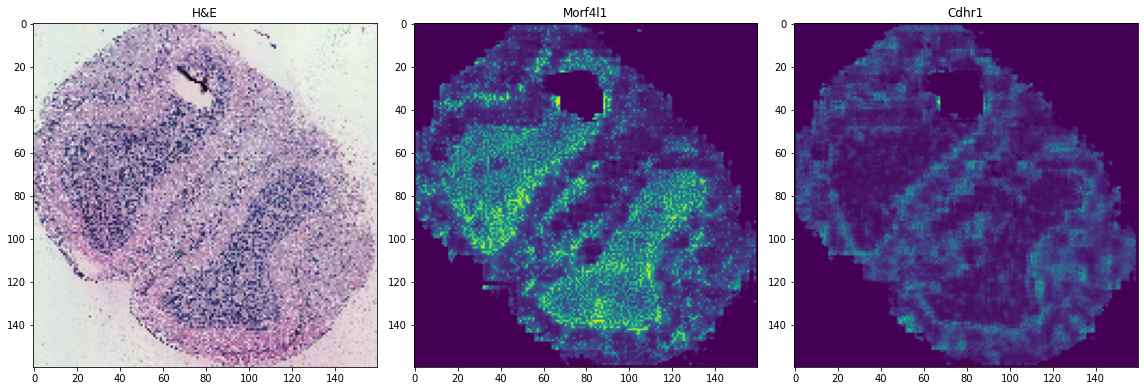

In [14]:
plot(he_images_training[-1], ["Morf4l1", "Cdhr1"])

## Next steps

You should now have an idea of how image-based super-resolution for spatial transcriptomics can be implemented.
If you have time left over and would like to learn more, you can find below a few additional ideas to explore on your own.
You will not have time to implement all of them during the lab, so pick the one you find most exciting!

1. When we created the `training_dataset` [above](#the-dataloader), we left out one of the sections from the dataset.
   An interesting application of the super-resolution method proposed in [1] is that it can be applied to histology images without associated gene expression data.
   Try redoing the analysis in the [inference section](#inference) using the omitted tissue section instead.
   How do the results compare to the results on sections included in the training set?

2. Similar to a gene embedding would be a ''section embedding'' that captures variability between different tissue sections.
   Try implementing a section embedding for the gene expression decoder and visualize it as we did with the gene embedding above.
   The dataset contains sections from five different mice.
   Can you identify which sections belong to the same mouse from the section embedding?

3. When we preprocessed the data [above](#preprocessing), we made the simplifying assumption that the spots form a pixel grid without any spacing.
   Try to relax this assumption by representing the spots as circles with a diameter of half the spot-to-spot distance, which is consistent with the layout of the ST array.
   _Tip_: You will need to change how gene expression in the super-resolved expression maps are aggregated to the spot-level in the [loss function](#loss-function)!

4. For machine learning experts: The architecture used in the model is similar to a [Very Deep VAE](https://arxiv.org/abs/2011.10650).
   How do they differ? Try rewriting the model as a Very Deep VAE and see how the results compare!

## References

[1]: Bergenstråhle, L., He, B., Bergenstråhle, J., Abalo, X., Mirzazadeh, R., Thrane, K., ... & Maaskola, J. (2022). Super-resolved spatial transcriptomics by deep data fusion. Nature Biotechnology, 40(4), 476-479.

[2]: Ståhl, P. L., Salmén, F., Vickovic, S., Lundmark, A., Navarro, J. F., Magnusson, J., ... & Frisén, J. (2016). Visualization and analysis of gene expression in tissue sections by spatial transcriptomics. Science, 353(6294), 78-82.